In [482]:
import torch
from diffusers import ControlNetModel

from text3d2video.generative_rendering.reposable_diffusion_pipeline import ReposableDiffusionPipeline
from text3d2video.noise_initialization import FixedNoiseInitializer

device = torch.device('cuda')
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

torch.set_grad_enabled(False)

pipe: ReposableDiffusionPipeline = ReposableDiffusionPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.noise_initializer = FixedNoiseInitializer()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

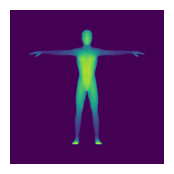

<Figure size 640x480 with 0 Axes>

In [483]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.ipython_utils import display_ims
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVOrthographicCameras

from text3d2video.utilities.mesh_processing import normalize_meshes

animation = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")
verts_uvs, faces_uvs = animation.uv_data()

meshes = load_objs_as_meshes(["data/meshes/mixamo-human.obj"]).to(device)
meshes = normalize_meshes(meshes)

R, T = front_facing_extrinsics()
s = 1.5

cams = FoVOrthographicCameras(R=R, T=T, device=device, scale_xyz=[(s, s, s)])
meshes = meshes.extend(len(cams))

depth_map = render_depth_map(meshes, cams)[0]

display_ims([depth_map])

In [484]:
import torchvision.transforms.functional as TF


def affine(im, translation=(0, 0), scale=1.0, angle=0.0):
    _, h, w = im.shape
    return TF.affine(
        im,
        translate=(translation[0] * h, translation[1] * w),
        scale=scale,
        angle=angle,
        shear=0.0,
    )

def affine_inv(im, translation=(0, 0), scale=1.0, angle=0.0):
    _, h, w = im.shape
    return TF.affine(
        im,
        translate=(-translation[0] * h, -translation[1] * w),
        scale=1/scale,
        angle=-angle,
        shear=0.0,
    )

In [485]:
translations = [(0, 0), (0.1, 0.1), (-0.1, -0.1), (-0.3, 0.3), (0.3, -0.3)]
angles = [60, 90, 180, 250 ]
zooms = [0.8, 1.2]

forward_funs = []
inverse_funs = []
for translation in translations:
    forward_funs.append(lambda im, translation=translation: affine(im, translation=translation))
    inverse_funs.append(lambda im, translation=translation: affine_inv(im, translation=translation))

for zoom in zooms:
    forward_funs.append(lambda im, zoom=zoom: affine(im, scale=zoom))
    inverse_funs.append(lambda im, zoom=zoom: affine_inv(im, scale=zoom))

for angle in angles:
    forward_funs.append(lambda im, angle=angle: affine(im, angle=angle))
    inverse_funs.append(lambda im, angle=angle: affine_inv(im, angle=angle))


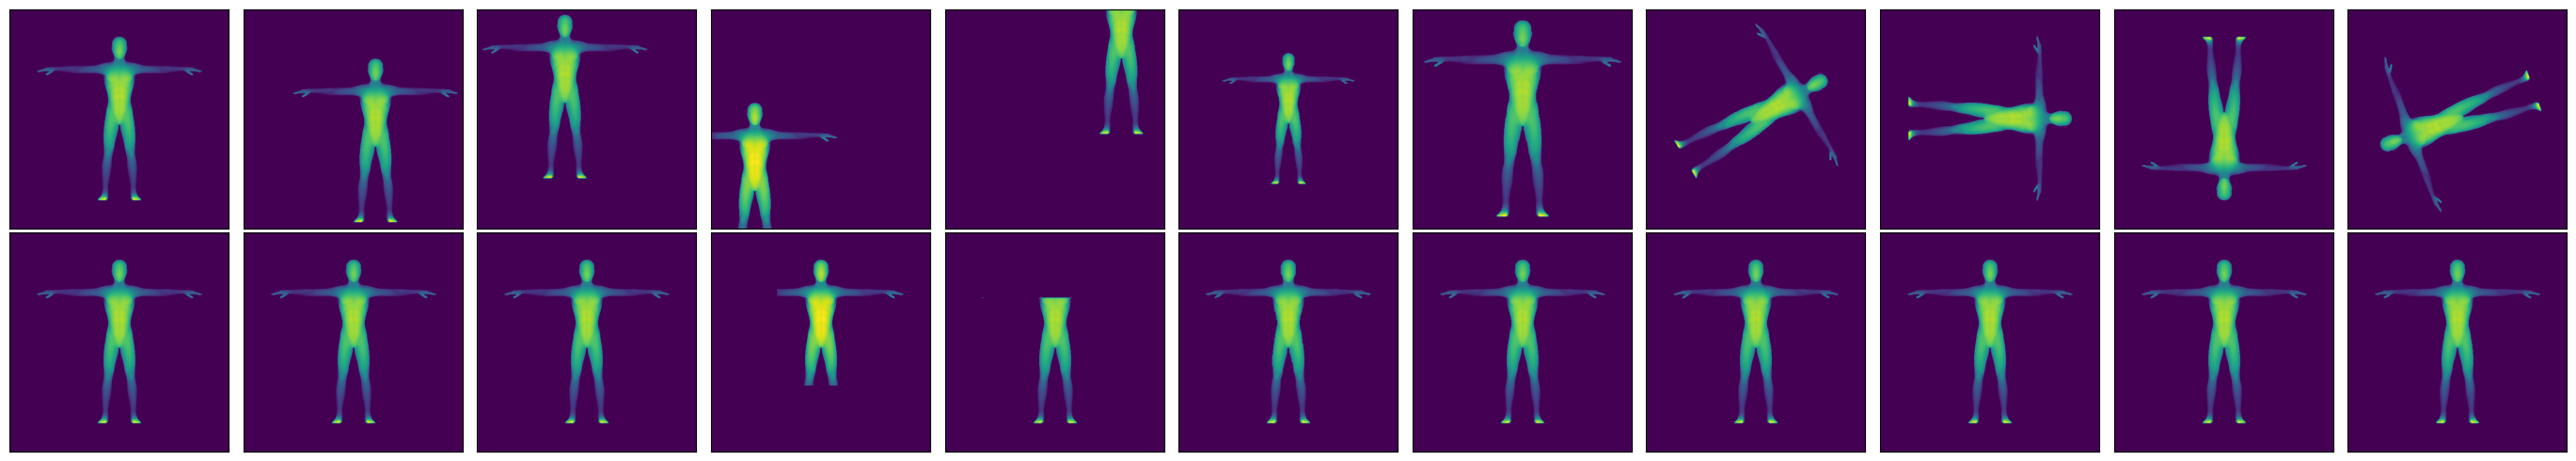

In [486]:

from text3d2video.utilities.ipython_utils import display_ims_grid

depth_maps = [f(TF.to_tensor(depth_map)) for f in forward_funs]
depth_maps = [TF.to_pil_image(x) for x in depth_maps]

depth_maps_aligned = [
    TF.to_pil_image(inv(TF.to_tensor(x))) for x, inv in zip(depth_maps, inverse_funs)
]

display_ims_grid([depth_maps, depth_maps_aligned])

In [487]:
prompt = "Deadpool"

pipe.scheduler.set_timesteps(10)

generator = torch.Generator(device=device)
generator.manual_seed(0)

embeddings, _ = pipe.encode_prompt([prompt] * len(depth_maps))
latents = pipe.noise_initializer.initial_noise(len(depth_maps))
t = pipe.scheduler.timesteps[0]

processed_control_image = pipe.prepare_controlnet_images(
    depth_maps, do_classifier_free_guidance=False
)

controlnet_out = pipe.controlnet(
    latents,
    t,
    encoder_hidden_states=embeddings,
    controlnet_cond=processed_control_image,
    return_dict=True,
)


down_block_res_samples = controlnet_out.down_block_res_samples
mid_block_res_sample = controlnet_out.mid_block_res_sample

controlnet_samples = down_block_res_samples + [mid_block_res_sample]


In [480]:
from einops import rearrange
import numpy as np
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.utilities.ipython_utils import display_ims_grid

feature_maps_pil = []
for sample in controlnet_samples:
    feature_maps = []
    features_flat = rearrange(sample, "b c h w -> (b h w) c").cpu()
    pca = RgbPcaUtil.init_from_features(features_flat)

    sample_ims = []

    for i, fmap in enumerate(sample):
        reduced = pca.feature_map_to_rgb_pil(fmap.cpu())
        reduced_hd = TF.resize(
            reduced, (512, 512), interpolation=TF.InterpolationMode.NEAREST
        )
        reduced_hd = TF.to_tensor(reduced_hd)
        aligned = inverse_funs[i](reduced_hd).cpu()
        aligned = TF.to_pil_image(aligned)
        sample_ims.append(aligned)

    feature_maps_pil.append(sample_ims)


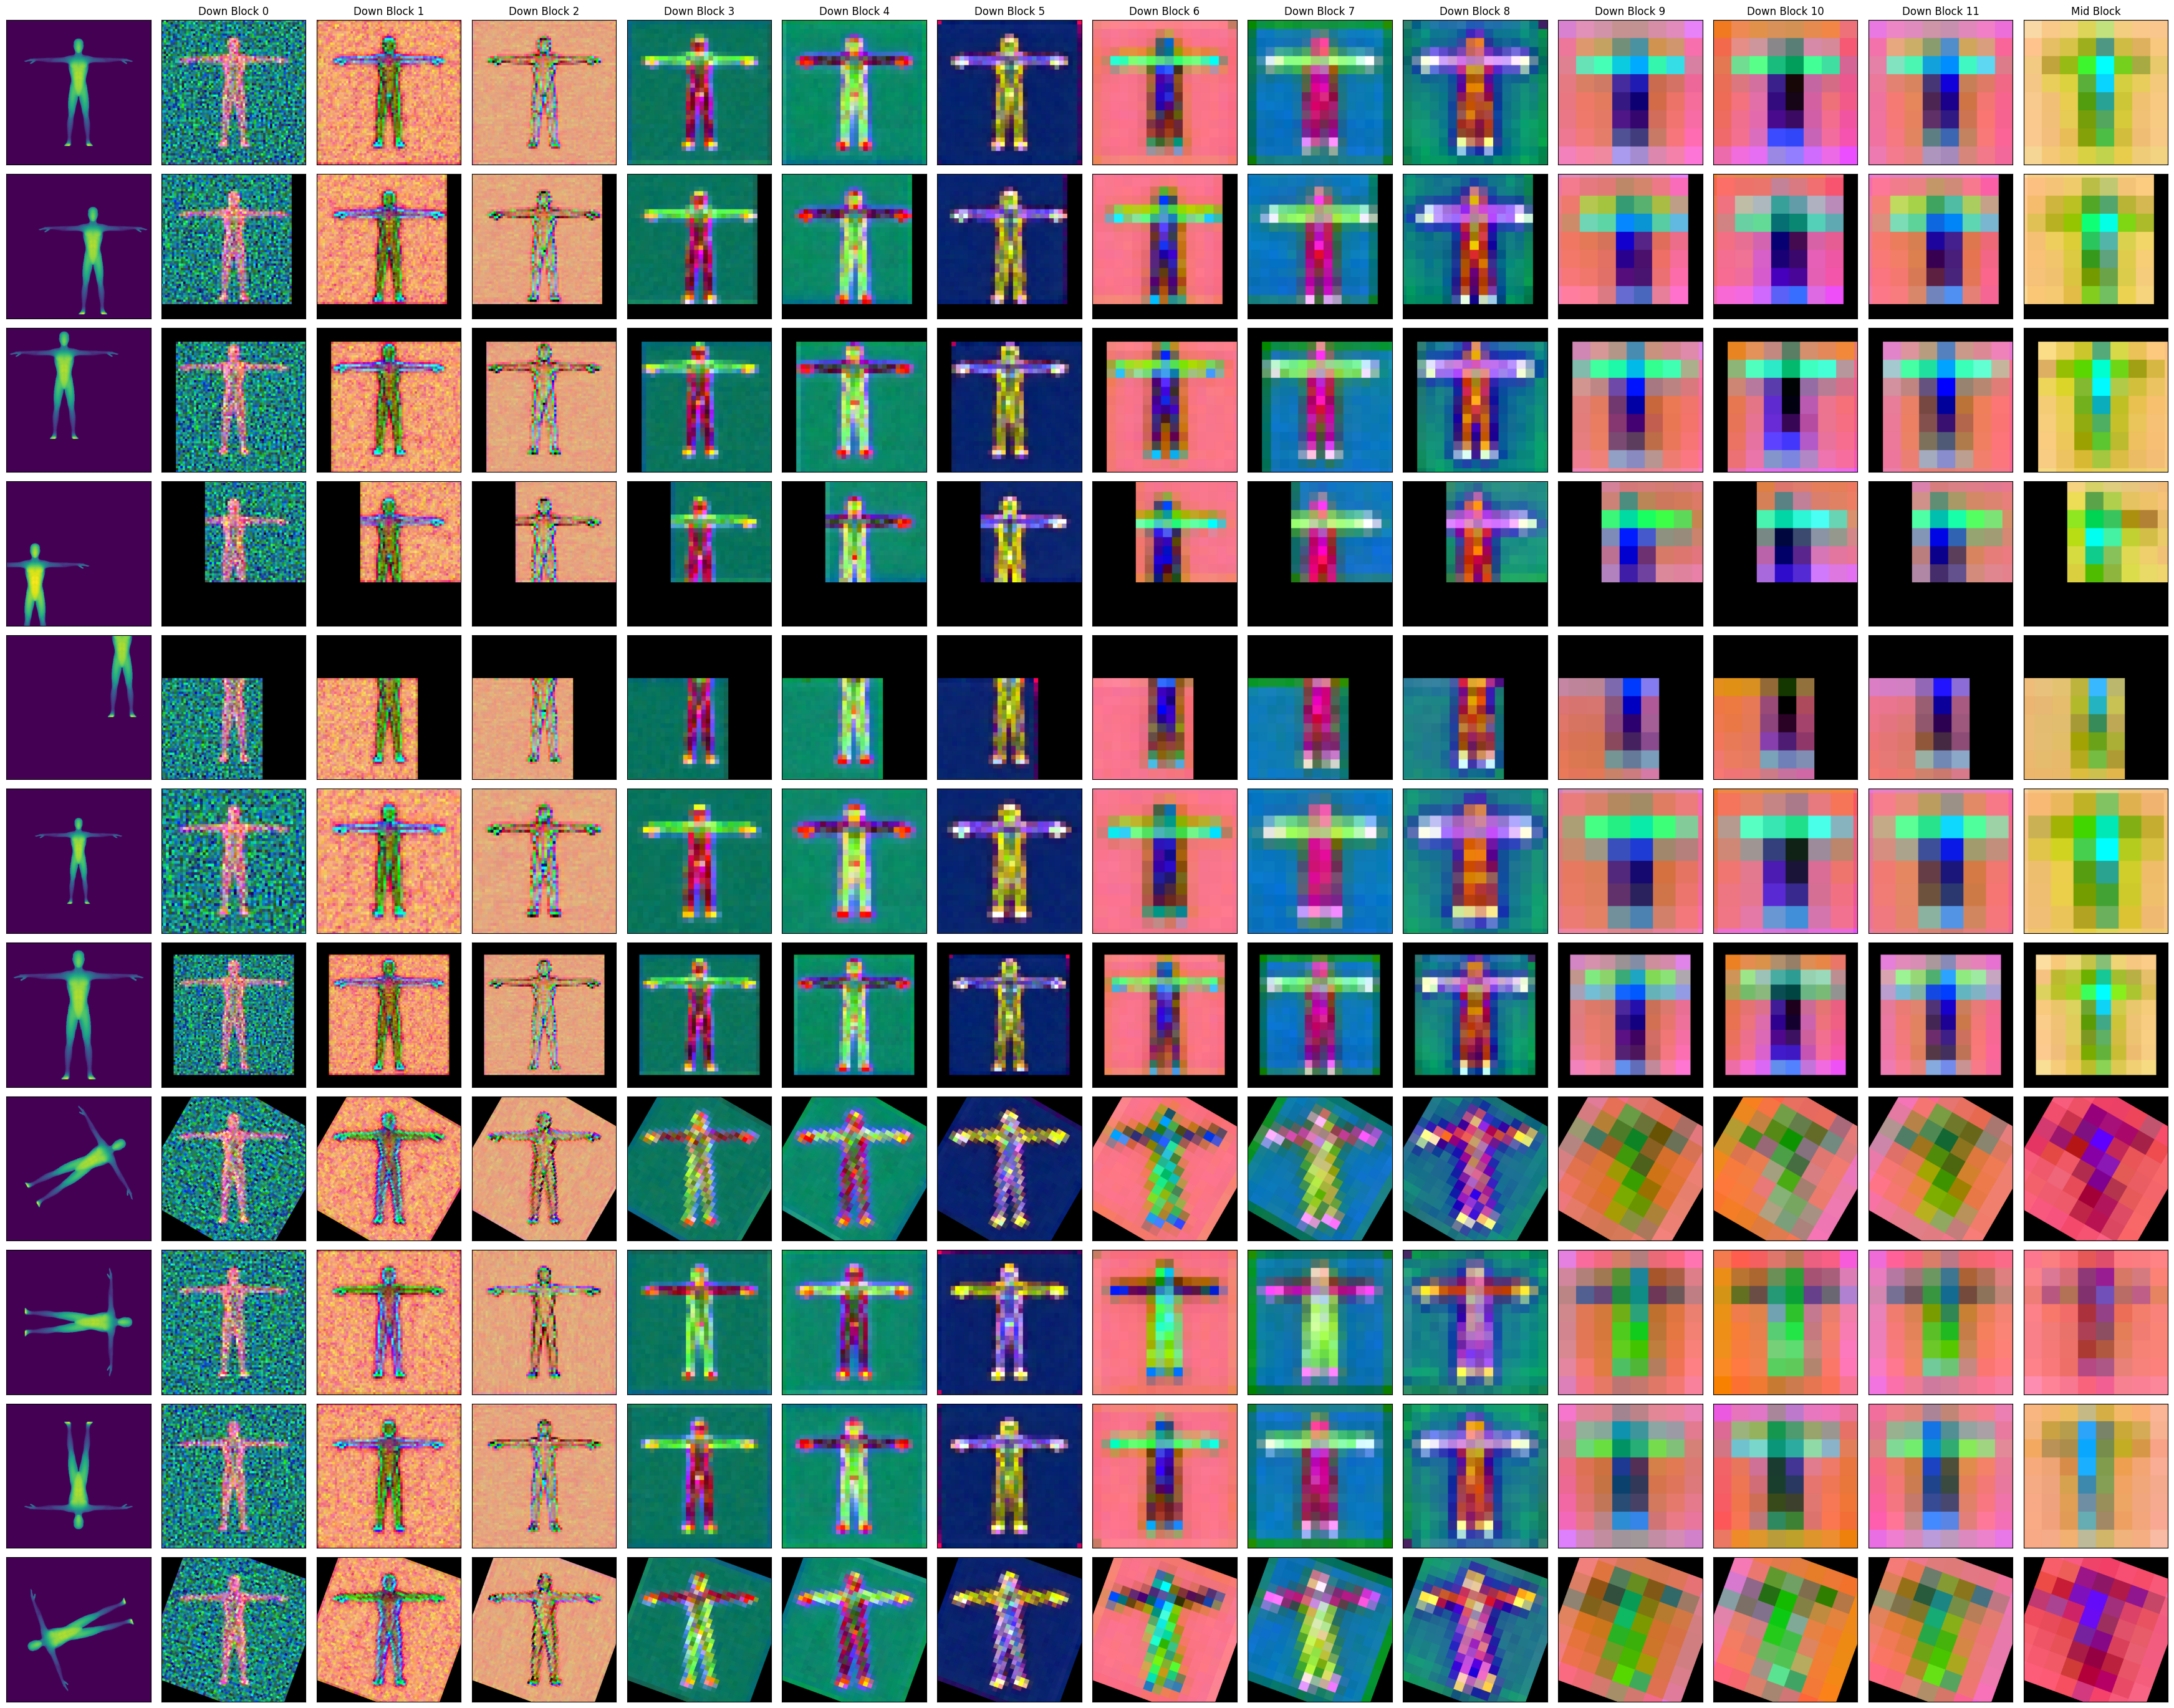

In [481]:
grid = np.empty((len(feature_maps_pil), len(feature_maps_pil[0])), dtype=object)
for i, row in enumerate(feature_maps_pil):
    for j, im in enumerate(row):
        grid[i, j] = im

grid = grid.T

depth_maps_arr = np.empty(len(depth_maps), dtype=object)
depth_maps_arr[:] = depth_maps

grid = np.column_stack((depth_maps_arr, grid))


titles = [""] + [f"Down Block {i}" for i in range(len(down_block_res_samples))] + ["Mid Block"]

display_ims_grid(grid, col_titles=titles)

In [431]:

depth_ims_arr = np.empty(len(depth_maps), dtype=object)
# depth_ims_arr[:] = depth_maps

# grid = np.concatenate([depth_ims_arr[:, None], feature_maps_pil], axis=1)
grid = feature_maps_pil
# display_ims_grid(grid)
